In [2]:
#!/usr/bin/env python

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import math
import pandas as pd
import wradlib
from scipy import stats
import matplotlib.cm as cm
my_cmap = cm.get_cmap('jet',40)
my_cmap.set_under('lightgrey')
my_cmap.set_over('darkred')
from pcc import get_miub_cmap as my_cmap
from pcc import plot_radar
from pcc import boxpol_pos
from pcc import plot_borders
import wradlib as wrl
from osgeo import osr
from satlib import ipoli_radi_stat
from satlib import corcor
Pos = boxpol_pos()
blon0, blat0 = Pos['lon_ppi'], Pos['lat_ppi']
bbx, bby = Pos['gkx_ppi'], Pos['gky_ppi']
from time import *
from pcc import cut_the_swath
from satlib import good_overpasses_dpr_boxpol as overpasses_dpr_boxpol

print ("_")



tstart = clock()

#print (overpasses_dpr_boxpol)

for ii in overpasses_dpr_boxpol.keys():
    ZP = overpasses_dpr_boxpol[ii][0],
    pfadnr = overpasses_dpr_boxpol[ii][1]
    enigma = overpasses_dpr_boxpol[ii][2]
    offset = overpasses_dpr_boxpol[ii][3]

    ZP = ZP[0]

    print type(ZP), type(pfadnr), type(enigma), type(offset)
    print ZP, pfadnr, enigma, offset
    #ZP = '20180125170330'; pfadnr=0; enigma='neu'; offset=1


    # Pfade zu den Dateien festlegen
    #-----------------------------#

    year = ZP[0:4]; ye = ZP[2:4]; m = ZP[4:6]; d = ZP[6:8]; ht = ZP[8:10]; mt = ZP[10:12]; st = ZP[12:14]

    print('/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.' + year + m + d + '*.HDF5')
    #pfad_radar = glob.glob('/automount/ags/velibor/gpmdata/dpr/2A.GPM.DPR.V6-20160118.' + year + m + d + '*.HDF5')
    pfad_radar = glob.glob('/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.' + year + m + d + '*.HDF5')

    print ('GPM:',pfad_radar)
    pfad_radar = pfad_radar[pfadnr]
    #pfad_radar_Ku = pfad_radar[0]

    deg_scan =  ["/ppi_1p5deg/","/ppi_2p4deg/","/ppi_3p4deg/",
                 "/n_ppi_010deg/","/n_ppi_045deg/",
                 "/n_ppi_082deg/","/n_ppi_110deg/","/n_ppi_140deg/",
                 "/n_ppi_180deg/","/n_ppi_280deg/","/n_vertical_scan/"][4]


    if enigma=='neu':
        print ('New enigma')
        deg_scan =  ["/n_ppi_010deg/"][0]

        boxpolpath = '/automount/radar/scans/' + year+ "/" +year +"-"+ m + "/" + year+ "-" + m +"-"+ d +\
                                   deg_scan+"*"+year+m+d+ht+mt+st+"*.h5"
        print (boxpolpath)
        ppi_datapath=glob.glob(boxpolpath)

        print ('Boxpol: ',ppi_datapath)
        ppi_datapath = ppi_datapath[0]


    else:
        try:
            ppi_datapath=glob.glob('/automount/radar-archiv/scans/' + year+ "/" +
                                   year +"-"+ m + "/" + year+ "-" + m +"-"+ d +
                                   deg_scan+ year + "-" + m +"-"+ d + "--" +ht +
                                   ":"+mt+":"+st+",*.mvol")
            print ppi_datapath
            ppi_datapath = ppi_datapath[0]

        except:
            ppi_datapath=glob.glob('/automount/radar/scans/' + year+ "/" +
                                   year +"-"+ m + "/" + year+ "-" + m +"-"+
                                   d + deg_scan+ year + "-" + m +"-"+ d +
                                   "--" +ht +":"+mt+":"+st+",*.mvol")
            print ('Old enigma')
            print ('Boxpol: ',ppi_datapath)
            ppi_datapath = ppi_datapath[0]


    # Wichtige Parameter festlegen
    TH = 15 #Threshold um Nullen fuer Niederschlag raus zu filtern


    #################################################### PPI BoxPol Daten einlesen
    #------------------------------------------------------------------------------

    ppi=h5py.File(ppi_datapath,'r')
    data, attrs = wradlib.io.read_GAMIC_hdf5(ppi_datapath)

    ZH0 = data['SCAN0']['ZH']['data']
    #ZV = data['SCAN0']['ZV']['data']
    #ZH0 = (ZH + ZV)*0.5
    PHIDP = data['SCAN0']['PHIDP']['data']
    r = attrs['SCAN0']['r']
    az = attrs['SCAN0']['az']
    elevation=attrs['SCAN0']['elevation']
    lon_ppi = attrs['VOL']['Longitude']
    lat_ppi = attrs['VOL']['Latitude']
    alt_ppi = attrs['VOL']['Height']
    rho = data['SCAN0']['RHOHV']['data']

    R = ZH0

    print ("________Beam Blockage______")
    R[151:165]=np.nan
    print (np.nanmax(R))

    print ("________CLUTTER______")
    rho_th  = 0.85
    R[rho<= rho_th] = np.nan
    print (np.nanmax(R))

    print ("________offset______")
    R = R - offset
    print (np.nanmax(R))
    #?
    print ("________ATTCORR______")

    """pia = wrl.atten.correctAttenuationHB(
        R,
        coefficients = dict(a=4.57e-5, b=0.731, gate_length=1.0),
        mode="warn",
        thrs=59.)
    pia[pia > 4.8] = 4.8

    print ("________ATTCORR2______")
    R = R + pia
    print (np.nanmax([R,pia]))"""

    print ("________DPR Threshold______")
    Z_boxpol = R

    ### Threshold for DPR sensitivity
    Z_boxpol[Z_boxpol<TH]=np.nan


    ################################################################# DPR Einlesen
    # -----------------------------------------------------------------------------
    scan = 'MS'
    gpmku = h5py.File(pfad_radar, 'r')
    gpmku_HS = gpmku[scan]['SLV']
    dpr_lat_1 = np.array(gpmku[scan]['Latitude'])
    dpr_lon_1 = np.array(gpmku[scan]['Longitude'])
    Z_dpr = np.array(gpmku_HS['zFactorCorrectedNearSurface'])
    Z_dpr[Z_dpr < TH] = np.nan

    ## Einlesen von Phase un Raintype
    dpr_raintype = np.array(gpmku[scan]['CSF']['typePrecip'], dtype=float)
    dpr_phase = np.array(gpmku_HS['phaseNearSurface'], dtype=float)


    ############################################################## RADOLAN einlesen
    # -----------------------------------------------------------------------------
    mtt = mt
    mtt = str(int(round(float(mtt)/5.0)*5.0))

    if mtt == '0':
        mtt = '00'
    if mtt == '5':
        mtt = '05'
    if mtt == '60':
        mtt = '55'

    r_pro = 'rx'

    pfad = ('/automount/radar/dwd/'+ r_pro +'/'+str(year)+'/'+str(year)+'-'+
            str(m)+'/'+ str(year)+'-'+str(m)+'-'+str(d)+'/raa01-'+r_pro+'_10000-'+
            str(ye)+str(m)+ str(d)+str(ht)+str(mtt)+'-dwd---bin.gz')

    print ('RADOLANPFAD: ', pfad)

    pfad_radolan = pfad[:-3]

    try:
        rw_filename = wradlib.util.get_wradlib_data_file(pfad)
    except EnvironmentError:
        rw_filename = wradlib.util.get_wradlib_data_file(pfad_radolan)

    rwdata, rwattrs = wradlib.io.read_RADOLAN_composite(rw_filename)

    radolan_zeit = rwattrs['datetime'].strftime("%Y.%m.%d -- %H:%M:%S")

    radolan_grid_xy = wradlib.georef.get_radolan_grid(900,900)
    x = radolan_grid_xy[:,:,0]
    y = radolan_grid_xy[:,:,1]
    rwdata = np.ma.masked_equal(rwdata, -9999) / 2 - 32.5

    ### Threshold for DPR sensitivity
    rwdata[rwdata<TH]=np.nan
    Z_radolan = rwdata


    ######################################################## Cut the Swath for Bonn
    # -----------------------------------------------------------------------------

    dpr_lon, dpr_lat, Z_dpr = cut_the_swath(dpr_lon_1,dpr_lat_1,Z_dpr, eu=0)
    dpr_lon, dpr_lat, dpr_raintype = cut_the_swath(dpr_lon_1,dpr_lat_1,dpr_raintype, eu=0)
    dpr_lon, dpr_lat, dpr_phase = cut_the_swath(dpr_lon_1,dpr_lat_1,dpr_phase, eu=0)

    ######################################################## Koordinaten Projektion
    # -----------------------------------------------------------------------------

    proj_stereo = wrl.georef.create_osr("dwd-radolan")
    proj_wgs = osr.SpatialReference()
    proj_wgs.ImportFromEPSG(4326)

    dpr_lon, dpr_lat = wradlib.georef.reproject(dpr_lon, dpr_lat,
                                                projection_target=proj_stereo ,
                                                projection_source=proj_wgs)

    blon, blat = wradlib.georef.reproject(blon0, blat0,
                                          projection_target=proj_stereo ,
                                          projection_source=proj_wgs)


    ############################################################### Dpr zuschneiden
    #------------------------------------------------------------------------------
    print ('Max --------------------------------------->', r[-1]/1000.)
    inner_r = 15. # in km!!!!

    print ('Min --------------------------------------->', inner_r)

    lon0, lat0, radius = blon, blat, r[-1]/1000.
    rr = np.sqrt((dpr_lat - lat0)**2 + (dpr_lon - lon0)**2)
    position = rr < radius

    # Maximum Range
    Z_dpr[np.where(rr > radius)] = np.nan
    dpr_raintype[np.where(rr > radius)] = np.nan
    dpr_phase[np.where(rr > radius)] = np.nan

    # Minimum Range
    Z_dpr[np.where(rr < inner_r)] = np.nan
    dpr_raintype[np.where(rr < inner_r)] = np.nan
    dpr_phase[np.where(rr < inner_r)] = np.nan


    ########################################################### RADOLAN zuschneiden
    #------------------------------------------------------------------------------

    rr2 = np.sqrt((y - lat0)**2 + (x - lon0)**2)
    position2 = rr2 < radius

    # Maximum Range
    Z_radolan[np.where(rr2 > radius)] = np.nan

    # Minimum Range
    Z_radolan[np.where(rr2 < inner_r)] = np.nan


    ########################################################### BoXPol zuschneiden
    #------------------------------------------------------------------------------
    # Minimum Range
    a = (inner_r*1000.)/(r[1]-r[0])# inner_r in m!!!!
    a = a.astype(int) # bin bis zu welchem radius alles NaN gesetzt wird
    Z_boxpol[:,0:a]=np.nan
    print (a)


    ############################################################### Inverse Dezibel
    #------------------------------------------------------------------------------
    Z_boxpol = wradlib.trafo.idecibel(Z_boxpol)
    Z_dpr = wradlib.trafo.idecibel(Z_dpr)
    Z_radolan = wradlib.trafo.idecibel(Z_radolan)

    ################################################## BoXPol interpolieren auf DPR
    #------------------------------------------------------------------------------
    t1 = clock()
    radar_location = (lon_ppi, lat_ppi, alt_ppi)
    #elevation = 1.5
    azimuths = az
    ranges = r
    polargrid = np.meshgrid(ranges, azimuths)
    lon, lat, alt = wradlib.georef.polar2lonlatalt_n(polargrid[0], polargrid[1],
                                                     elevation, radar_location)
    lon, lat = wradlib.georef.reproject(lon, lat, projection_target=proj_stereo ,
                                        projection_source=proj_wgs)

    grid_xy = np.vstack((dpr_lon.ravel(), dpr_lat.ravel())).transpose()

    xy=np.concatenate([lon.ravel()[:,None],lat.ravel()[:,None]], axis=1)



    Z_boxpol_ipoli, Z_boxpol_ipoli_std, Z_boxpol_ipoli_median, Z_boxpol_ipoli_max, Z_boxpol_ipoli_min = ipoli_radi_stat(xy,Z_boxpol.ravel(),grid_xy,2.5)
    
    Z_boxpol_ipoli = Z_boxpol_ipoli.reshape(dpr_lon.shape)
    Z_boxpol_ipoli_std = Z_boxpol_ipoli_std.reshape(dpr_lon.shape)
    Z_boxpol_ipoli_median = Z_boxpol_ipoli_median.reshape(dpr_lon.shape)
    Z_boxpol_ipoli_max = Z_boxpol_ipoli_max.reshape(dpr_lon.shape)
    Z_boxpol_ipoli_min = Z_boxpol_ipoli_min.reshape(dpr_lon.shape)

    t2 = clock()
    print ('Interpolationsdauer Boxpol auf DPR:', t2 - t1)


    ################################################# RADOLAN interpolieren auf DPR
    #------------------------------------------------------------------------------

    xy_rado = np.vstack((x.ravel(), y.ravel())).transpose()

    Z_radolan_ipoli, Z_radolan_ipoli_std, Z_radolan_ipoli_median, Z_radolan_ipoli_max, Z_radolan_ipoli_min = ipoli_radi_stat(xy_rado,Z_radolan.ravel().filled(np.nan),grid_xy,2.5)
    
    Z_radolan_ipoli = Z_radolan_ipoli.reshape(dpr_lon.shape)
    Z_radolan_ipoli_std = Z_radolan_ipoli_std.reshape(dpr_lon.shape)
    Z_radolan_ipoli_median = Z_radolan_ipoli_median.reshape(dpr_lon.shape)
    Z_radolan_ipoli_max = Z_radolan_ipoli_max.reshape(dpr_lon.shape)
    Z_radolan_ipoli_min = Z_radolan_ipoli_min.reshape(dpr_lon.shape)

    t3 = clock()
    print ('Interpolationsdauer RADOLAN auf DPR:', t3 - t2)

    ################################################################### in  Dezibel
    #------------------------------------------------------------------------------
    Z_boxpol = wradlib.trafo.decibel(Z_boxpol)
    Z_dpr = wradlib.trafo.decibel(Z_dpr)
    Z_radolan = wradlib.trafo.decibel(Z_radolan)
    Z_boxpol_ipoli = wradlib.trafo.decibel(Z_boxpol_ipoli)
    Z_radolan_ipoli = wradlib.trafo.decibel(Z_radolan_ipoli)
    
    Z_boxpol_ipoli_std = wradlib.trafo.decibel(Z_boxpol_ipoli_std)
    Z_radolan_ipoli_std = wradlib.trafo.decibel(Z_radolan_ipoli_std)
    Z_boxpol_ipoli_median = wradlib.trafo.decibel(Z_boxpol_ipoli_median)
    Z_radolan_ipoli_median = wradlib.trafo.decibel(Z_radolan_ipoli_median)
    Z_boxpol_ipoli_max = wradlib.trafo.decibel(Z_boxpol_ipoli_max)
    Z_radolan_ipoli_max = wradlib.trafo.decibel(Z_radolan_ipoli_max)
    Z_boxpol_ipoli_min = wradlib.trafo.decibel(Z_boxpol_ipoli_min)
    Z_radolan_ipoli_min = wradlib.trafo.decibel(Z_radolan_ipoli_min)


    #zwischenspeichern
    np.save('/automount/ags/velibor/data/dpr_boxpol_radolan/stat/minus_bias/'+ZP+'.npy',
            [Z_dpr, Z_boxpol, Z_boxpol_ipoli, Z_radolan, Z_radolan_ipoli, dpr_phase, dpr_raintype, dpr_lon, dpr_lat, 
             Z_boxpol_ipoli_std, Z_boxpol_ipoli_median, Z_boxpol_ipoli_max, Z_boxpol_ipoli_min,
             Z_radolan_ipoli_std, Z_radolan_ipoli_median, Z_radolan_ipoli_max, Z_radolan_ipoli_min])

tend = clock()
print ('Gesamtlaufzeit: ',(tend-tstart)/60., 'min')



_
<type 'str'> <type 'int'> <type 'str'> <type 'float'>
20170519110333 0 neu 1.0
/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20170519*.HDF5
('GPM:', ['/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20170519-S102835-E120109.018308.V05A.HDF5'])
New enigma
/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_010deg/*20170519110333*.h5
('Boxpol: ', ['/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_010deg/n_ppi_010deg_12345_20170519110333_00.h5'])
________Beam Blockage______
67.609375
________CLUTTER______
67.609375
________offset______
66.609375
________ATTCORR______
________DPR Threshold______
('RADOLANPFAD: ', '/automount/radar/dwd/rx/2017/2017-05/2017-05-19/raa01-rx_10000-1705191105-dwd---bin.gz')
('Max --------------------------------------->', 150.0)
('Min --------------------------------------->', 15.0)
75


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:297: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.
satlib.py:895: RuntimeWarning: Mean of empty slice
  gr_ipoli_data[i] = np.nanmean(gr_data[rr < radius])
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
satlib.py:898: RuntimeWarning: All-NaN slice encountered
  gr_ipoli_max[i] = np.nanmax(gr_data[rr < radius])


('Interpolationsdauer Boxpol auf DPR:', 39.120423)
('Interpolationsdauer RADOLAN auf DPR:', 128.52925399999998)
<type 'str'> <type 'int'> <type 'str'> <type 'float'>
20150330233003 1 alt 2.0
/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20150330*.HDF5
('GPM:', ['/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20150330-S055056-E072328.006155.V05A.HDF5', '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20150330-S224903-E002135.006166.V05A.HDF5'])
[]
Old enigma
('Boxpol: ', ['/automount/radar/scans/2015/2015-03/2015-03-30/n_ppi_045deg/2015-03-30--23:30:03,00.mvol'])
________Beam Blockage______
43.789062
________CLUTTER______
42.22461
________offset______
40.22461
________ATTCORR______
________DPR Threshold______
('RADOLANPFAD: ', '/automount/radar/dwd/rx/2015/2015-03/2015-03-30/raa01-rx_10000-1503302330-dwd---bin.gz')
('Max --------------------------------------->', 150.0)
('Min --------------------------------------->', 15.0)
100


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:297: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


('Interpolationsdauer Boxpol auf DPR:', 57.51465300000001)
('Interpolationsdauer RADOLAN auf DPR:', 121.00957)
<type 'str'> <type 'int'> <type 'str'> <type 'float'>
20151015203657 1 alt 2.0
/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20151015*.HDF5
('GPM:', ['/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20151015-S115821-E133055.009255.V05A.HDF5', '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20151015-S194118-E211352.009260.V05A.HDF5'])
[]
Old enigma
('Boxpol: ', ['/automount/radar/scans/2015/2015-10/2015-10-15/n_ppi_045deg/2015-10-15--20:36:57,00.mvol'])
________Beam Blockage______
50.00586
________CLUTTER______
49.566406
________offset______
47.566406
________ATTCORR______
________DPR Threshold______
('RADOLANPFAD: ', '/automount/radar/dwd/rx/2015/2015-10/2015-10-15/raa01-rx_10000-1510152035-dwd---bin.gz')
('Max --------------------------------------->', 150.0)
('Min --------------------------------------->', 15.0)
100


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:297: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


('Interpolationsdauer Boxpol auf DPR:', 41.60774199999997)
('Interpolationsdauer RADOLAN auf DPR:', 113.74102699999997)
<type 'str'> <type 'int'> <type 'str'> <type 'float'>
20170909021332 0 neu 1.0
/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20170909*.HDF5
('GPM:', ['/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20170909-S013353-E030627.020060.V05A.HDF5'])
New enigma
/automount/radar/scans/2017/2017-09/2017-09-09/n_ppi_010deg/*20170909021332*.h5
('Boxpol: ', ['/automount/radar/scans/2017/2017-09/2017-09-09/n_ppi_010deg/n_ppi_010deg_12345_20170909021332_00.h5'])
________Beam Blockage______
60.13867
________CLUTTER______
44.20117
________offset______
43.20117
________ATTCORR______
________DPR Threshold______
('RADOLANPFAD: ', '/automount/radar/dwd/rx/2017/2017-09/2017-09-09/raa01-rx_10000-1709090215-dwd---bin.gz')
('Max --------------------------------------->', 150.0)
('Min --------------------------------------->', 15.0)
75


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:297: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


('Interpolationsdauer Boxpol auf DPR:', 41.51082299999996)
('Interpolationsdauer RADOLAN auf DPR:', 125.4860940000001)
<type 'str'> <type 'int'> <type 'str'> <type 'float'>
20151216024501 0 alt 2.0
/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20151216*.HDF5
('GPM:', ['/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20151216-S014742-E032015.010213.V05A.HDF5', '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20151216-S184555-E201828.010224.V05A.HDF5'])
[]
Old enigma
('Boxpol: ', ['/automount/radar/scans/2015/2015-12/2015-12-16/n_ppi_045deg/2015-12-16--02:45:01,00.mvol'])
________Beam Blockage______
48.804688
________CLUTTER______
48.804688
________offset______
46.804688
________ATTCORR______
________DPR Threshold______
('RADOLANPFAD: ', '/automount/radar/dwd/rx/2015/2015-12/2015-12-16/raa01-rx_10000-1512160245-dwd---bin.gz')
('Max --------------------------------------->', 150.0)
('Min --------------------------------------->', 15.0)
100


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:297: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


('Interpolationsdauer Boxpol auf DPR:', 41.05662300000006)
('Interpolationsdauer RADOLAN auf DPR:', 107.883197)
<type 'str'> <type 'int'> <type 'str'> <type 'float'>
20170211153000 0 alt 3.5
/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20170211*.HDF5
('GPM:', ['/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20170211-S144911-E162144.016802.V05A.HDF5'])
[]
Old enigma
('Boxpol: ', ['/automount/radar/scans/2017/2017-02/2017-02-11/n_ppi_045deg/2017-02-11--15:30:00,00.mvol'])
________Beam Blockage______
37.583984
________CLUTTER______
37.583984
________offset______
34.083984
________ATTCORR______
________DPR Threshold______
('RADOLANPFAD: ', '/automount/radar/dwd/rx/2017/2017-02/2017-02-11/raa01-rx_10000-1702111530-dwd---bin.gz')
('Max --------------------------------------->', 150.0)
('Min --------------------------------------->', 15.0)
100


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:297: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


('Interpolationsdauer Boxpol auf DPR:', 47.45134100000007)
('Interpolationsdauer RADOLAN auf DPR:', 123.45165899999995)
<type 'str'> <type 'int'> <type 'str'> <type 'float'>
20160601175950 1 alt 3.5
/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20160601*.HDF5
('GPM:', ['/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20160601-S002009-E015243.012826.V05A.HDF5', '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20160601-S171836-E185110.012837.V05A.HDF5'])
[]
Old enigma
('Boxpol: ', ['/automount/radar/scans/2016/2016-06/2016-06-01/n_ppi_045deg/2016-06-01--17:59:50,00.mvol'])
________Beam Blockage______
60.30664
________CLUTTER______
60.30664
________offset______
56.80664
________ATTCORR______
________DPR Threshold______
('RADOLANPFAD: ', '/automount/radar/dwd/rx/2016/2016-06/2016-06-01/raa01-rx_10000-1606011755-dwd---bin.gz')
('Max --------------------------------------->', 150.0)
('Min --------------------------------------->', 15.0)
100


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:297: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


('Interpolationsdauer Boxpol auf DPR:', 45.64480800000001)
('Interpolationsdauer RADOLAN auf DPR:', 121.20911799999999)
<type 'str'> <type 'int'> <type 'str'> <type 'float'>
20170321043000 0 alt 3.5
/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20170321*.HDF5
('GPM:', ['/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20170321-S035103-E052338.017386.V05A.HDF5'])
[]
Old enigma
('Boxpol: ', ['/automount/radar/scans/2017/2017-03/2017-03-21/n_ppi_045deg/2017-03-21--04:30:00,00.mvol'])
________Beam Blockage______
44.07617
________CLUTTER______
44.07617
________offset______
40.57617
________ATTCORR______
________DPR Threshold______
('RADOLANPFAD: ', '/automount/radar/dwd/rx/2017/2017-03/2017-03-21/raa01-rx_10000-1703210430-dwd---bin.gz')
('Max --------------------------------------->', 150.0)
('Min --------------------------------------->', 15.0)
100


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:297: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


('Interpolationsdauer Boxpol auf DPR:', 47.48588700000005)
('Interpolationsdauer RADOLAN auf DPR:', 122.54592200000002)
<type 'str'> <type 'int'> <type 'str'> <type 'float'>
20170211153000 0 alt 3.5
/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20170211*.HDF5
('GPM:', ['/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20170211-S144911-E162144.016802.V05A.HDF5'])
[]
Old enigma
('Boxpol: ', ['/automount/radar/scans/2017/2017-02/2017-02-11/n_ppi_045deg/2017-02-11--15:30:00,00.mvol'])
________Beam Blockage______
37.583984
________CLUTTER______
37.583984
________offset______
34.083984
________ATTCORR______
________DPR Threshold______
('RADOLANPFAD: ', '/automount/radar/dwd/rx/2017/2017-02/2017-02-11/raa01-rx_10000-1702111530-dwd---bin.gz')
('Max --------------------------------------->', 150.0)
('Min --------------------------------------->', 15.0)
100


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:297: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


('Interpolationsdauer Boxpol auf DPR:', 47.1224400000001)
('Interpolationsdauer RADOLAN auf DPR:', 122.75464699999998)
<type 'str'> <type 'int'> <type 'str'> <type 'float'>
20170810110333 0 neu 1.0
/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20170810*.HDF5
('GPM:', ['/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20170810-S102212-E115444.019599.V05A.HDF5'])
New enigma
/automount/radar/scans/2017/2017-08/2017-08-10/n_ppi_010deg/*20170810110333*.h5
('Boxpol: ', ['/automount/radar/scans/2017/2017-08/2017-08-10/n_ppi_010deg/n_ppi_010deg_12345_20170810110333_00.h5'])
________Beam Blockage______
65.61719
________CLUTTER______
61.134766
________offset______
60.134766
________ATTCORR______
________DPR Threshold______
('RADOLANPFAD: ', '/automount/radar/dwd/rx/2017/2017-08/2017-08-10/raa01-rx_10000-1708101105-dwd---bin.gz')
('Max --------------------------------------->', 150.0)
('Min --------------------------------------->', 15.0)
75


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:297: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


('Interpolationsdauer Boxpol auf DPR:', 36.29935699999987)
('Interpolationsdauer RADOLAN auf DPR:', 117.40411700000004)
<type 'str'> <type 'int'> <type 'str'> <type 'float'>
20171126032331 0 neu 1.0
/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20171126*.HDF5
('GPM:', ['/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20171126-S024618-E041852.021274.V05A.HDF5'])
New enigma
/automount/radar/scans/2017/2017-11/2017-11-26/n_ppi_010deg/*20171126032331*.h5
('Boxpol: ', ['/automount/radar/scans/2017/2017-11/2017-11-26/n_ppi_010deg/n_ppi_010deg_12345_20171126032331_00.h5'])
________Beam Blockage______
49.679688
________CLUTTER______
48.185547
________offset______
47.185547
________ATTCORR______
________DPR Threshold______
('RADOLANPFAD: ', '/automount/radar/dwd/rx/2017/2017-11/2017-11-26/raa01-rx_10000-1711260325-dwd---bin.gz')
('Max --------------------------------------->', 150.0)
('Min --------------------------------------->', 15.0)
75


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:297: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


('Interpolationsdauer Boxpol auf DPR:', 35.90111999999999)
('Interpolationsdauer RADOLAN auf DPR:', 118.488067)
<type 'str'> <type 'int'> <type 'str'> <type 'float'>
20140826221000 1 alt 2.0
/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20140826*.HDF5
('GPM:', ['/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20140826-S133117-E150350.002799.V05A.HDF5', '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20140826-S211407-E224640.002804.V05A.HDF5'])
['/automount/radar-archiv/scans/2014/2014-08/2014-08-26/n_ppi_045deg/2014-08-26--22:10:00,00.mvol']
________Beam Blockage______
42.819336
________CLUTTER______
42.819336
________offset______
40.819336
________ATTCORR______
________DPR Threshold______
('RADOLANPFAD: ', '/automount/radar/dwd/rx/2014/2014-08/2014-08-26/raa01-rx_10000-1408262210-dwd---bin.gz')
('Max --------------------------------------->', 150.0)
('Min --------------------------------------->', 15.0)
100


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:297: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


('Interpolationsdauer Boxpol auf DPR:', 32.875676999999996)
('Interpolationsdauer RADOLAN auf DPR:', 84.15136700000016)
<type 'str'> <type 'int'> <type 'str'> <type 'float'>
20140806203538 1 alt 2.0
/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20140806*.HDF5
('GPM:', ['/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20140806-S025632-E042905.002481.V05A.HDF5', '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20140806-S195445-E212718.002492.V05A.HDF5'])
['/automount/radar-archiv/scans/2014/2014-08/2014-08-06/n_ppi_045deg/2014-08-06--20:35:38,00.mvol']
________Beam Blockage______
33.335938
________CLUTTER______
33.335938
________offset______
31.335938
________ATTCORR______
________DPR Threshold______
('RADOLANPFAD: ', '/automount/radar/dwd/rx/2014/2014-08/2014-08-06/raa01-rx_10000-1408062035-dwd---bin.gz')
('Max --------------------------------------->', 150.0)
('Min --------------------------------------->', 15.0)
100


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:297: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


('Interpolationsdauer Boxpol auf DPR:', 47.83331799999996)
('Interpolationsdauer RADOLAN auf DPR:', 122.03982100000007)
<type 'str'> <type 'int'> <type 'str'> <type 'float'>
20141008094000 1 alt 2.0
/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20141008*.HDF5
('GPM:', ['/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20141008-S010511-E023741.003460.V05A.HDF5', '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20141008-S084747-E102017.003465.V05A.HDF5'])
['/automount/radar-archiv/scans/2014/2014-10/2014-10-08/n_ppi_045deg/2014-10-08--09:40:00,00.mvol']
________Beam Blockage______
40.648438
________CLUTTER______
40.648438
________offset______
38.648438
________ATTCORR______
________DPR Threshold______
('RADOLANPFAD: ', '/automount/radar/dwd/rx/2014/2014-10/2014-10-08/raa01-rx_10000-1410080940-dwd---bin.gz')
('Max --------------------------------------->', 150.0)
('Min --------------------------------------->', 15.0)
100


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:297: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


('Interpolationsdauer Boxpol auf DPR:', 33.73136799999975)
('Interpolationsdauer RADOLAN auf DPR:', 86.63731300000018)
<type 'str'> <type 'int'> <type 'str'> <type 'float'>
20141007023744 0 alt 2.0
/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20141007*.HDF5
('GPM:', ['/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20141007-S015721-E032951.003445.V05A.HDF5'])
['/automount/radar-archiv/scans/2014/2014-10/2014-10-07/n_ppi_045deg/2014-10-07--02:37:44,00.mvol']
________Beam Blockage______
45.054688
________CLUTTER______
45.054688
________offset______
43.054688
________ATTCORR______
________DPR Threshold______
('RADOLANPFAD: ', '/automount/radar/dwd/rx/2014/2014-10/2014-10-07/raa01-rx_10000-1410070235-dwd---bin.gz')
('Max --------------------------------------->', 150.0)
('Min --------------------------------------->', 15.0)
100


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:297: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


('Interpolationsdauer Boxpol auf DPR:', 46.86607700000013)
('Interpolationsdauer RADOLAN auf DPR:', 118.70936600000005)
<type 'str'> <type 'int'> <type 'str'> <type 'float'>
20170725152833 0 neu 1.0
/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20170725*.HDF5
('GPM:', ['/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20170725-S144757-E162031.019353.V05A.HDF5'])
New enigma
/automount/radar/scans/2017/2017-07/2017-07-25/n_ppi_010deg/*20170725152833*.h5
('Boxpol: ', ['/automount/radar/scans/2017/2017-07/2017-07-25/n_ppi_010deg/n_ppi_010deg_12345_20170725152833_00.h5'])
________Beam Blockage______
58.64453
________CLUTTER______
58.64453
________offset______
57.64453
________ATTCORR______
________DPR Threshold______
('RADOLANPFAD: ', '/automount/radar/dwd/rx/2017/2017-07/2017-07-25/raa01-rx_10000-1707251530-dwd---bin.gz')
('Max --------------------------------------->', 150.0)
('Min --------------------------------------->', 15.0)
75


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:297: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


('Interpolationsdauer Boxpol auf DPR:', 32.91543200000024)
('Interpolationsdauer RADOLAN auf DPR:', 116.50259099999994)
<type 'str'> <type 'int'> <type 'str'> <type 'float'>
20170211152500 0 alt 3.5
/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20170211*.HDF5
('GPM:', ['/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20170211-S144911-E162144.016802.V05A.HDF5'])
[]
Old enigma
('Boxpol: ', ['/automount/radar/scans/2017/2017-02/2017-02-11/n_ppi_045deg/2017-02-11--15:25:00,00.mvol'])
________Beam Blockage______
36.432617
________CLUTTER______
36.432617
________offset______
32.932617
________ATTCORR______
________DPR Threshold______
('RADOLANPFAD: ', '/automount/radar/dwd/rx/2017/2017-02/2017-02-11/raa01-rx_10000-1702111525-dwd---bin.gz')
('Max --------------------------------------->', 150.0)
('Min --------------------------------------->', 15.0)
100


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:297: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


('Interpolationsdauer Boxpol auf DPR:', 46.4529950000001)
('Interpolationsdauer RADOLAN auf DPR:', 119.74704800000018)
('Gesamtlaufzeit: ', 44.957320349999996, 'min')


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationW

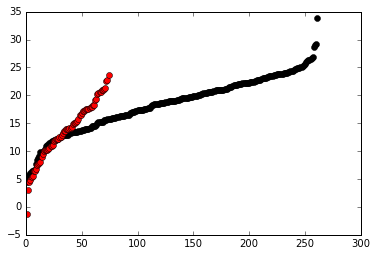

In [3]:
% matplotlib inline
plt.plot(np.unique(Z_radolan_ipoli_std), 'ok')
plt.plot(np.unique(Z_boxpol_ipoli_std),'or')

plt.show()

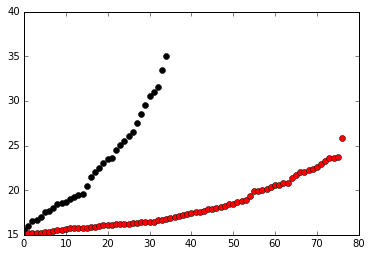

In [4]:
plt.plot(np.unique(Z_radolan_ipoli_median), 'ok')
plt.plot(np.unique(Z_boxpol_ipoli_median),'or')

plt.show()

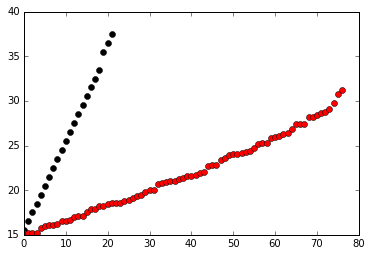

In [5]:
plt.plot(np.unique(Z_radolan_ipoli_max), 'ok')
plt.plot(np.unique(Z_boxpol_ipoli_max),'or')

plt.show()

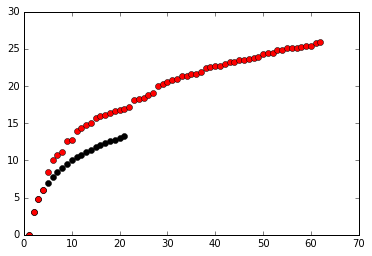

In [6]:
plt.plot(np.unique(Z_radolan_ipoli_min), 'ok')
plt.plot(np.unique(Z_boxpol_ipoli_min),'or')
#plt.scatter(Z_radolan_ipoli_min,Z_boxpol_ipoli_min)
plt.show()

In [7]:
, Z_radolan_ipoli_median, Z_radolan_ipoli_max, Z_radolan_ipoli_min

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
a = np.array([np.nan,np.nan,1,2,3,4.4,5.6,7.8])

In [ ]:
len(a
   )

In [ ]:
np.count_nonzero(~np.isnan(a))

In [12]:
np.exp(1./1.)

2.718281828459045